In [5]:
# Imports & stuff

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from cycler import cycler





# Constants
time = 1800
pres = []
all_envs = ["ABC", "Tiger", "RockSample5", "RockSample10", "K-out-of-N2", "K-out-of-N3", 
            "FrozenLake4", "FrozenLake10", "Tag", "Hallway1", "Hallway2", "MiniHallway", "TigerGrid"] # All envs
Env_to_latex_name = {
    "ABC" : "\\custom",
    "Tiger":"\\tiger",
    "RockSample5": "\\rocksample (5)",
    "RockSample10": "\\rocksample (10)",
    "K-out-of-N2":"\\koutofn (2)",
    "K-out-of-N3":"\\koutofn (3)",
    "FrozenLake4":"\\lake (4)",
    "FrozenLake10":"\\lake (10)",
    "Tag":"\\tagenv",
    "Hallway1":"\\hallway1",
    "Hallway2":"\\hallway2",
    "TigerGrid":"\\tigergrid",
    "MiniHallway":"\\minihallway"
}



# all_envs = ["ABC", "Tiger", "RockSample5", "FrozenLake4"] #Testing envs
pre = "./Data/Sarsoptest_"
post = f"_t{time}.json"
for env in all_envs:
    pres.append(pre + env + "_" )

def get_data(env:str):
    ts, ubs, lbs = [], [], []
    solvernames, envname = [], ""
    for s in ["SARSOP", "BIB-SARSOP", "EBIB-SARSOP"]:
        with open(pre+env+"_"+s+post) as file:
            data = json.load(file)
            ts.append(data["times"])
            ubs.append(data["ubs"])
            lbs.append(data["lbs"])
            solvernames.append(data["solver"])
            envname = data["env_full"]

    return ts, ubs, lbs, solvernames, envname





In [2]:
# Table of computation times

def get_vars(data:dict):
    if data["timeout"]:
        diff =  abs((data["final_ub"] - data["final_lw"] ) / data["final_lw"])
        # return f'- ({diff:.2f})'
        return f'- ({data["final_lw"]:.2f}, {data["final_ub"]:.2f})'
    else:
        return f'{data["runtime"]:.2f}s'


# labels = ["\\SARSOP", "\\BIBSARSOP", "\\EBIBSARSOP"]
labels = ["None", "\\BIB", "\\EBIB"]
names, Sarsop_time, BibSarsop_time, EBibSarsop_time = [], [], [], []

for pre in pres:
    filename_Sarsop = pre + "SARSOP" + post
    with open(filename_Sarsop) as file:
        this_data = json.load(file)
        # names.append(this_data["env_full"])
        names.append(Env_to_latex_name[this_data["env"]])
        Sarsop_time.append(get_vars(this_data))

    filename_BibSarsop = pre + "BIB-SARSOP" + post
    with open(filename_BibSarsop) as file:
        this_data = json.load(file)
        BibSarsop_time.append(get_vars(this_data))

    filename_EBibSarsop = pre + "EBIB-SARSOP" + post
    with open(filename_EBibSarsop) as file:
        this_data = json.load(file)
        EBibSarsop_time.append(get_vars(this_data))

dataframe = pd.DataFrame([Sarsop_time, BibSarsop_time, EBibSarsop_time], index=labels, columns=names).transpose()

print(dataframe)

print(dataframe.to_latex(column_format="l|ccc"))

                               None                \BIB               \EBIB
\custom                       0.28s               2.99s               3.55s
\tiger                       16.55s               7.67s               5.20s
\rocksample (5)               0.46s               2.65s               3.10s
\rocksample (10)   - (25.19, 25.63)    - (25.19, 25.62)    - (25.19, 25.63)
\koutofn (2)       - (-8.42, -6.42)    - (-8.43, -6.91)    - (-8.43, -6.88)
\koutofn (3)      - (-13.03, -4.23)  - (-16.15, -10.20)  - (-16.12, -10.17)
\lake (4)                     0.50s               3.83s               6.16s
\lake (10)           - (0.52, 0.54)      - (0.52, 0.54)      - (0.52, 0.54)
\tagenv           - (-10.87, -6.39)   - (-10.92, -6.43)   - (-10.91, -6.11)
\hallway1            - (5.08, 6.17)      - (3.41, 6.05)      - (3.22, 5.99)
\hallway2            - (4.12, 5.17)      - (4.03, 5.01)      - (3.85, 4.99)
\minihallway         - (7.57, 8.01)      - (7.48, 7.95)      - (7.46, 7.95)
\tigergrid  

### Plotting

403 4.8216559091751785
416 3.1456089645176997
321 2.7066681801391543


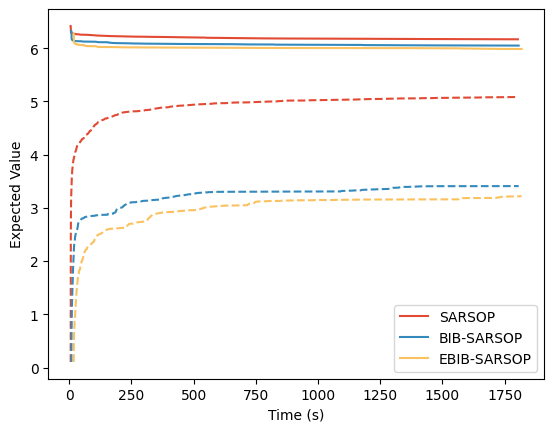

In [43]:
# TigerGrid

ts, ubs, lbs, solvernames, envname = get_data("Hallway1")

colours =  ['#E24A33', '#348ABD',  '#FBC15E', '#8EBA42', '#FFB5B8']

# colours = [(226, 74, 51), (52, 138, 189), (152, 142, 213)]

for (i,label) in enumerate(solvernames):
    plt.plot(ts[i],ubs[i], label=label, color=colours[i], linestyle="-")
    plt.plot(ts[i],lbs[i], label=None, color=colours[i], linestyle="--")
    print(len(ts[i]), lbs[i][171])
plt.xlabel("Time (s)")
plt.ylabel("Expected Value")
plt.legend()
plt.show()





